In [1]:
import numpy as np
import cPickle
from implementations.advanced.advanced_answer_extraction import AdvancedAnswerExtraction
from implementations.advanced.anwer_extraction import BaselineAnswerExtraction
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
answer_extractor = AdvancedAnswerExtraction()
baseline_extractor = BaselineAnswerExtraction()

## Loading the data

In [3]:
X, y, questionIdsMatchingRows = np.load("data/X_data.npy"), np.load("data/y_targets.npy"), cPickle.load(open("data/q_id_list.pickle", "rb"))
sentencesMatchingRows = cPickle.load(open("data/sentences_order_extraction.pickle", "rb"))
question_dict = cPickle.load(open("pickles/questions.pickle"))
patterns = cPickle.load(open("pickles/patterns.pickle"))
with open("pickles/question_labeled_sentence_dict.pickle", "rb") as f:
    qsDict = cPickle.load(f)
qIdList = cPickle.load(open("data/shuffled_IDs.pickle", "rb"))


## Importing and initializing SVM

In [4]:
from sklearn import svm
from sklearn.preprocessing import PolynomialFeatures

In [5]:
clf = svm.LinearSVC(C=2 ** -13, class_weight={1: 300})
#poly = PolynomialFeatures(1)
#X = poly.fit_transform(X)
clf.fit(X, y);

## Methods for calculating MRR and retrieving answers

In [6]:
def retrieve_sentences(yPredict, qIdsForXRows, yTestLabels, sentencesForXRows):
    qScoreDict = {}
    for i in range(len(yPredict)):
        qId = qIdsForXRows[i]
        score = yPredict[i]
        label = yTestLabels[i]
        sentence_text = sentencesForXRows[i]
        if qId not in qScoreDict:
            qScoreDict[qId] = [(score, label, sentence_text)]
        else:
            qScoreDict[qId].append((score, label, sentence_text))

    dictionary_extraction = {}
    for qId in qScoreDict.keys():
        sortedList = sorted(qScoreDict[qId], key=lambda x: x[0], reverse=True)
        found = False
        curr_extraction = []
        for i in range(min(len(sortedList), 20)):
            score, label, text = sortedList[i]
            curr_extraction.append((text, score))

        dictionary_extraction[qId] = curr_extraction

    return dictionary_extraction

def getRowIndexes(qIdListOriginal, qIdList, questionSentenceDict):
    index = 0
    start = qIdListOriginal.index(qIdList[0])
    end = qIdListOriginal.index(qIdList[-1])+1

    for qId in qIdListOriginal[:start]:
        index += len(questionSentenceDict[qId])

    startIndex = int(index)

    for qId in qIdListOriginal[start:end]:
        index += len(questionSentenceDict[qId])

    endIndex = int(index)

    return startIndex, endIndex

def getInputRows(X, y, qIdList, qIdTrain, qIdTest, qsDict, questionIdsMatchingXRows, shuffledSentences):
    testIndexStart, testIndexEnd = getRowIndexes(qIdList, qIdTest, qsDict)

    if testIndexStart >= testIndexEnd:
        print testIndexStart, testIndexEnd

    firstX = X[0:testIndexStart]
    secondX = X[testIndexEnd:]
    firstY = y[0:testIndexStart]
    secondY = y[testIndexEnd:]

    Xtrain = np.vstack((firstX, secondX))
    yTrain = np.hstack((firstY, secondY))

    Xtest = X[testIndexStart:testIndexEnd]
    yTest = y[testIndexStart:testIndexEnd]

    # return np.concatenate([np.array([similarity, jaccard_similarity, overlap, bigram_overlap]), sentence_length, question_length, question_type, sentence_type])
    poly = PolynomialFeatures(1)
    qIdsForXRows = questionIdsMatchingXRows[testIndexStart:testIndexEnd]  # question ids for each row in test set
    if shuffledSentences is not None:
        sentencesForXRows = shuffledSentences[testIndexStart:testIndexEnd]
    else:
        sentencesForXRows = []

    #print Xtrain.shape, Xtest.shape
    #Xtrain = poly.fit_transform(Xtrain)
    #Xtest = poly.fit_transform(Xtest)


    return Xtrain, yTrain, Xtest, yTest, qIdsForXRows, sentencesForXRows

def getDataForIndex(index, X, y):
    Xtrain, yTrain, Xtest, yTest, qIdsForXRows, sentencesForXRows = getInputRows(X, y, qIdList, [], [index], qsDict, questionIdsMatchingRows, sentencesMatchingRows)
    return Xtest, yTest, qIdsForXRows, sentencesForXRows

### Factoido in business

In [7]:
def get_answer_for_question(key, should_print_sentences = True, should_print_scores = True, print_limit=3, use_baseline=False):
    testData, TestLabels, qIdsForXRows, sentencesForXRows = getDataForIndex(str(key), X, y)
    predicted_y = clf.decision_function(testData)
    sent_dict = retrieve_sentences(predicted_y, qIdsForXRows, TestLabels, sentencesForXRows)
    sentences = sent_dict[str(key)]
    print "Question: " + question_dict[int(key)]
    for i, sent in enumerate(sentences[:print_limit]):
        print "RANK: " + str(i) + " score: " + str(sent[1]) + "\n\t" + sent[0]
    if use_baseline:
        answer = baseline_extractor.extract(question_dict[int(key)], sentences)
    else:
        answer = answer_extractor.extract(question_dict[int(key)], sentences)
    print "\n"
    print "EXTRACTED ANSWER: " + answer
    #return answer

def print_answer(answer):
    print "EXTRACTED ANSWER: " + str(answer)

In [8]:
get_answer_for_question(373)

Question: Where is the Kalahari desert?
RANK: 0 score: 1.11872295479
	It is fertile , unlike Botswana , which is blanketed by the Kalahari desert .
RANK: 1 score: 1.11062955957
	Probably the best reserve in Africa for elephant viewing , it lies on the high Kalahari Desert plain 500 miles west of Kariba .
RANK: 2 score: 1.10721628969
	Most of Botswana is blanketed by the Kalahari Desert , where bushmen still hunt with arrows as they have for centuries .


EXTRACTED ANSWER: Botswana


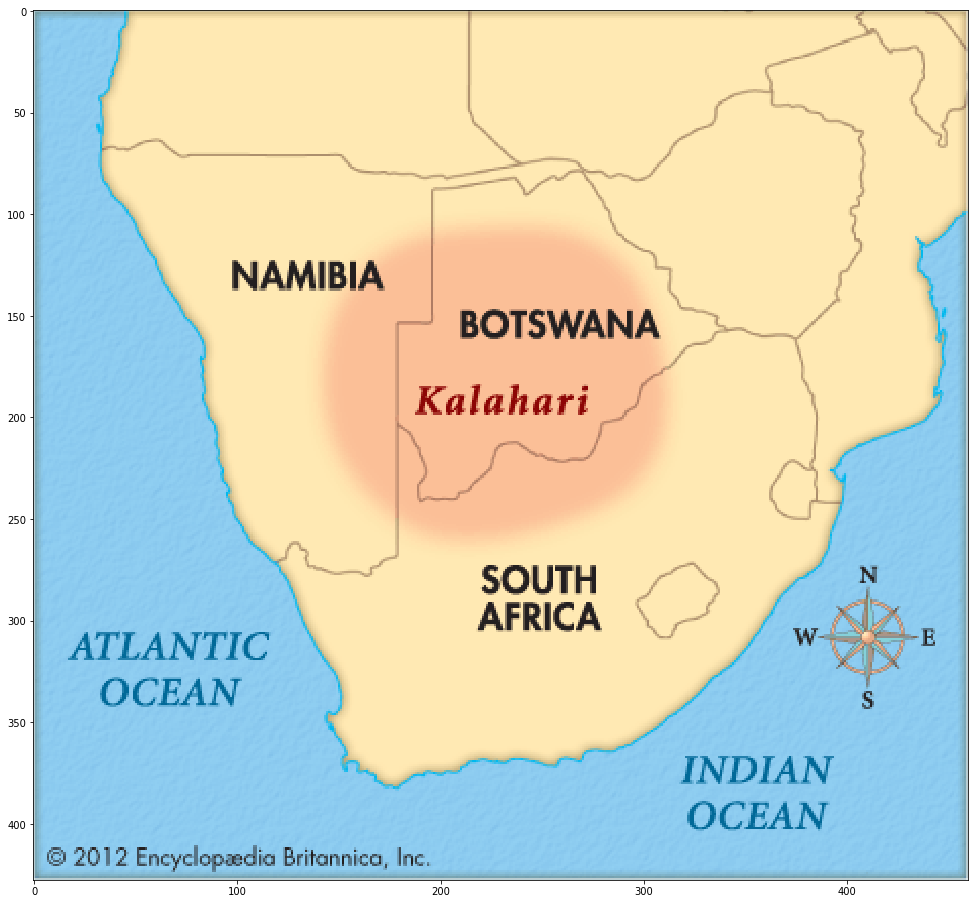

In [9]:
image = Image.open("HELP/kalahari.gif")
plt.figure(figsize=(24, 16))
plt.imshow(image)

In [10]:
get_answer_for_question(338)

Question: Who invented basketball?
RANK: 0 score: 1.17397701102
	Fact : Oregon State basketball Coach Ralph Miller , retiring this year after 38 years in the business , knew James Naismith , who invented the game .
RANK: 1 score: 1.09486745394
	Paul Brown may not have invented pro football , but he invented the modern pro football operation , both on and off the field .
RANK: 2 score: 1.08379206565
	The sport originated in Maplewood , N.J. , in 1968 when a group of reporters on the newspaper at Columbia High invented a game involving a Frisbee .


EXTRACTED ANSWER: James Naismith


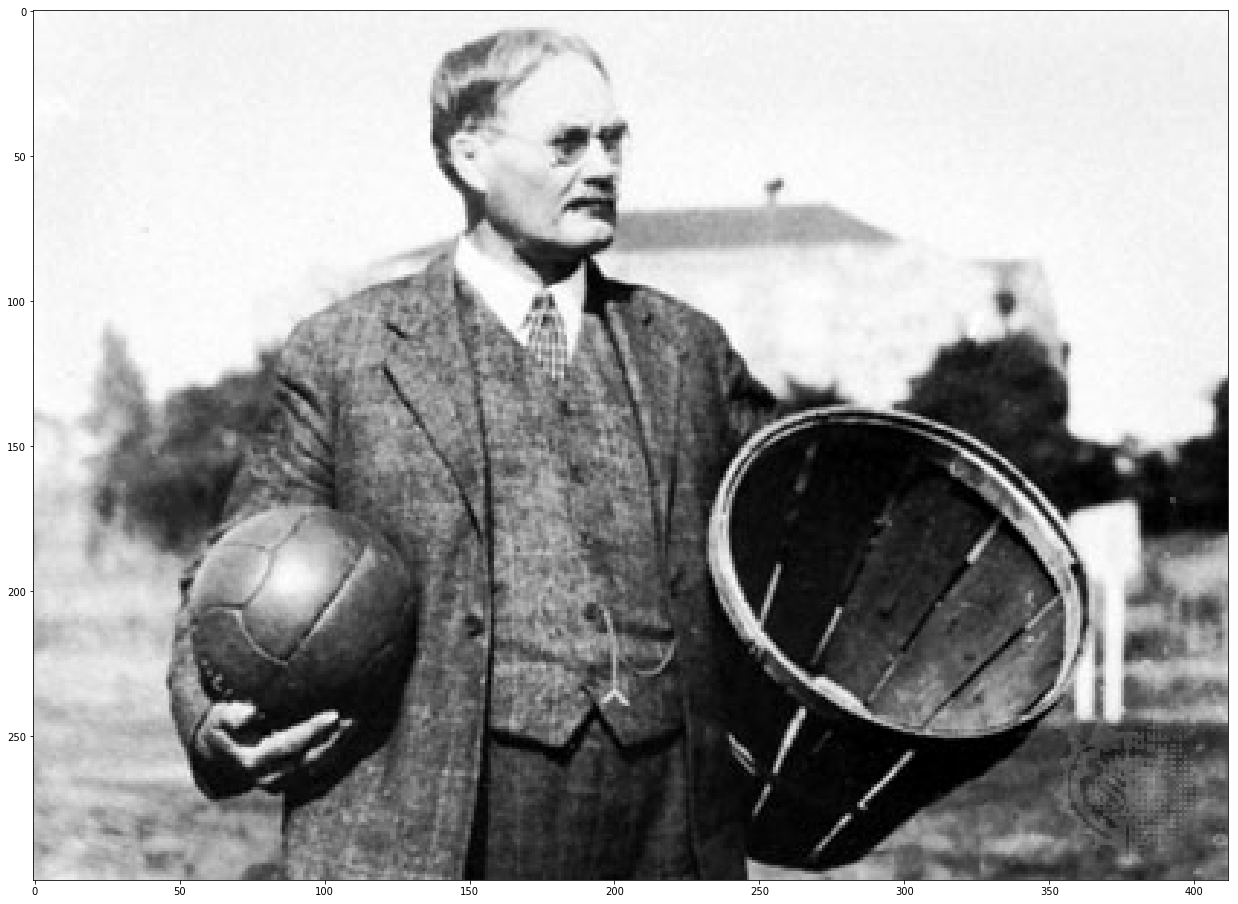

In [11]:
image = Image.open("HELP/james_naismith.jpg")
plt.figure(figsize=(24, 16))
plt.imshow(image, cmap="gray")

In [12]:
get_answer_for_question(640)

Question: When was the first Wall Street Journal published?
RANK: 0 score: 1.24968669462
	In 1889 , The Wall Street Journal was first published .
RANK: 1 score: 1.15669204863
	The Wall Street Journal will not be published tomorrow ,
RANK: 2 score: 1.15577987451
	Today`s Wall Street Journal is published in one section .


EXTRACTED ANSWER: 1889


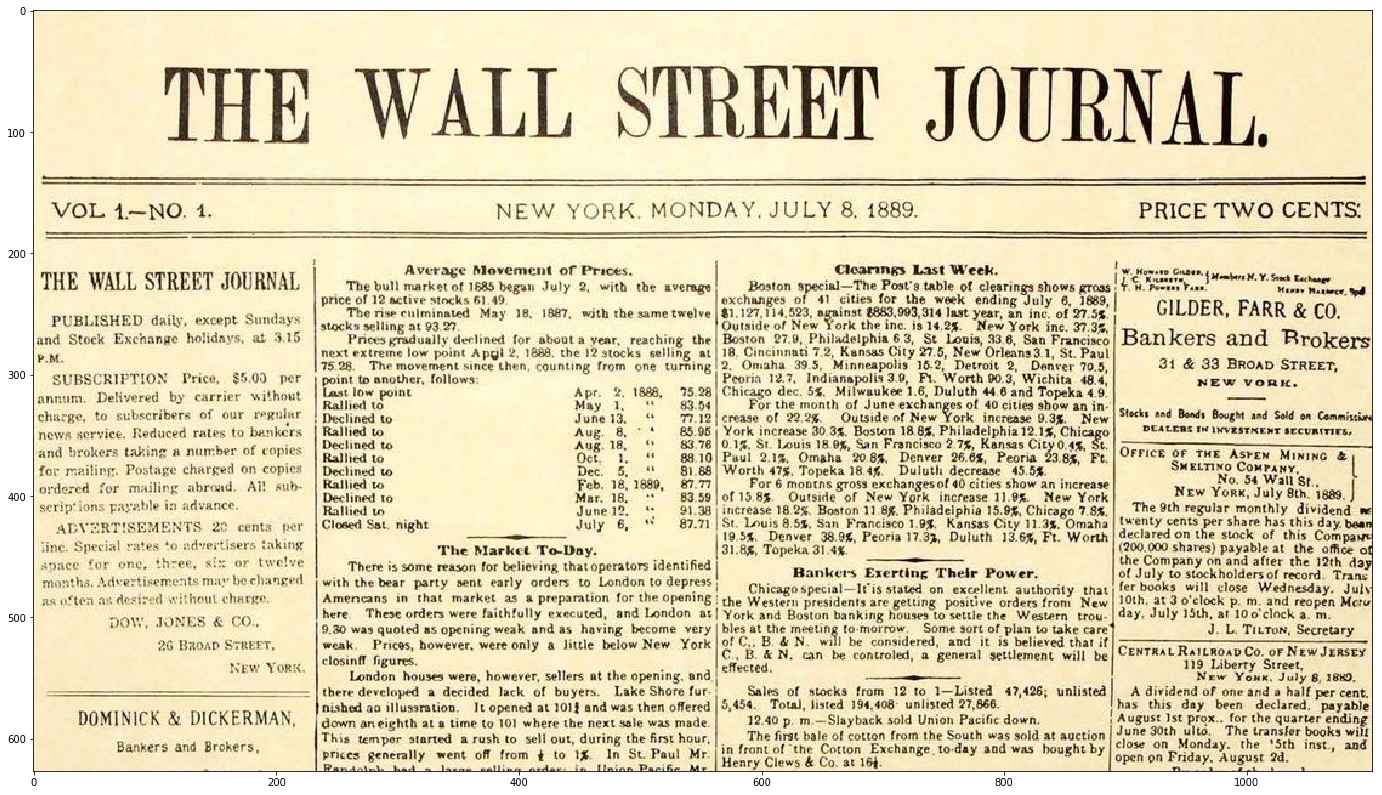

In [13]:
image = Image.open("HELP/first_wall_street.jpg")
plt.figure(figsize=(24, 16))
plt.imshow(image)

In [14]:
get_answer_for_question(776)

Question: What city's airport is named Logan International?
RANK: 0 score: 1.09738071099
	They said he fired randomly down at the city during a three - hour flight over greater Boston , hitting buildings and airplanes parked at Logan International Airport .
RANK: 1 score: 1.08894722167
	; The saga of Continental Airlines and Teresa Fischette , a part - time ticket agent at Logan International Airport in Boston , is a variation on that theme .
RANK: 2 score: 1.08003608747
	A British Airways flight bound for Miami from London made an emergency landing at Logan International Airport on Saturday after an anonymous caller threatened that a bomb would explode in flight .


EXTRACTED ANSWER: Boston


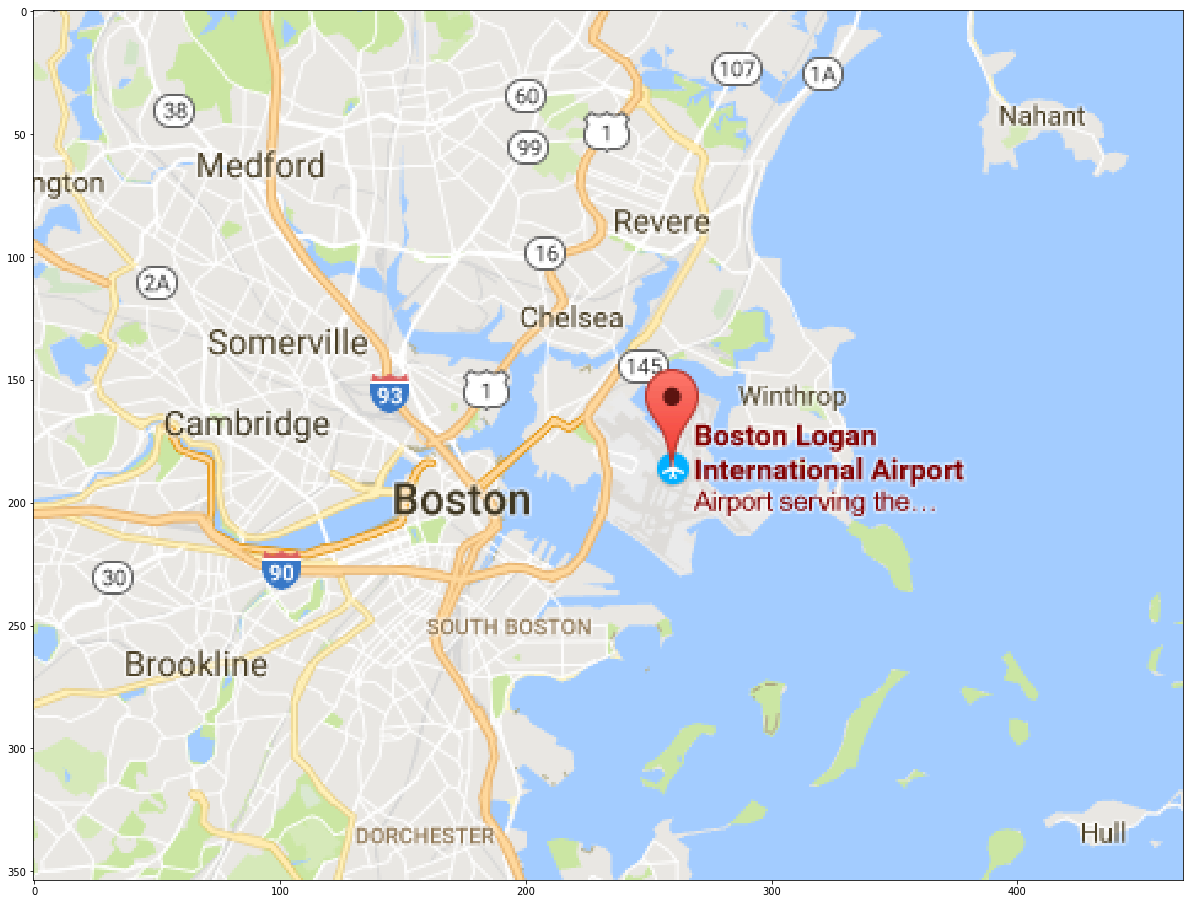

In [15]:
image = Image.open("HELP/boston_airport.png")
plt.figure(figsize=(24, 16))
plt.imshow(image)

In [16]:
print question_dict[297]

What did brontosauruses eat?


In [17]:
get_answer_for_question(297, use_baseline=True)

Question: What did brontosauruses eat?
RANK: 0 score: 1.07605342099
	`` People are just not in the habit of eating right , and when they do eat fruits and vegetables they eat the same things , `` Bunch said .
RANK: 1 score: 1.02986131492
	Nationwide , 45 percent of Americans don`t eat fruit or drink juice during the day , and 22 percent don`t eat vegetables or salads , Ms. Bunch said .
RANK: 2 score: 1.01972529579
	You eat and drink too much .


EXTRACTED ANSWER: Mars Bars


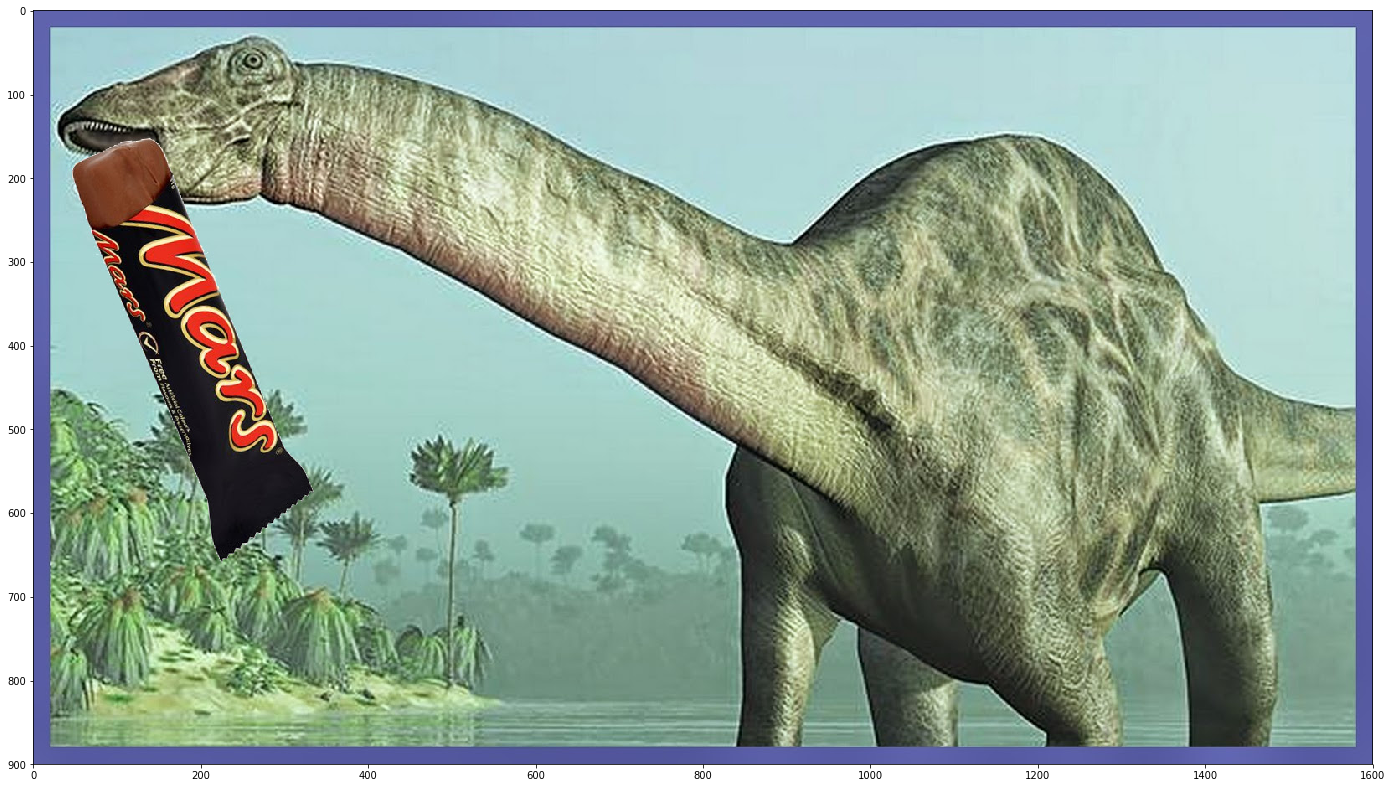

In [18]:
image = Image.open("HELP/top_kek.jpg")
plt.figure(figsize=(24, 16))
plt.imshow(image)

In [19]:
print question_dict[785]

What was the name of Darth Vader's son?


In [20]:
get_answer_for_question(785)

Question: What was the name of Darth Vader's son?
RANK: 0 score: 1.11410739428
	They wanted a kind of Darth Vader voice .
RANK: 1 score: 1.09939573633
	Bill was like Darth Vader .
RANK: 2 score: 1.04739820836
	`` The phacops rana can be found in many areas of Pennsylvania , `` Lepone said , adding that the creature `` reminds us of Darth Vader from ` Star Wars .


EXTRACTED ANSWER: Bill


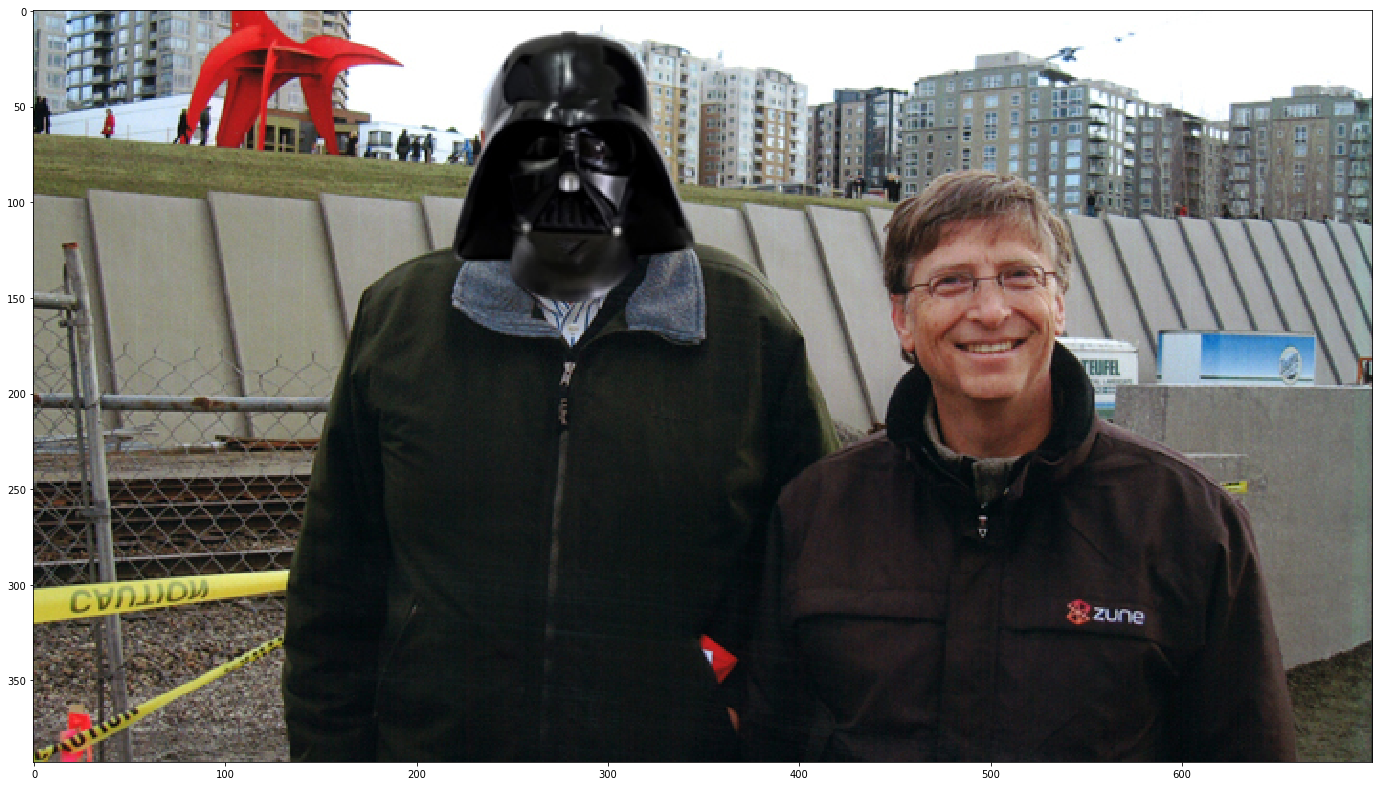

In [21]:
image = Image.open("HELP/vader_son.jpg")
plt.figure(figsize=(24, 16))
plt.imshow(image)